## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ##
## [3. Create train, test and validation generators](#generators) ##
## [4. Create a function to show Training Image Samples](#show) ##
## [5. Create the Model](#model) ##
## [6. Create a custom Keras callback to continue or halt training](#callback) ##
## [7. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [8. Train the model](#train) ##
## [9. Define a function to plot the training data](#plot) ##
## [10. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [11 Save the model](#save) ##
## [12 Plot Validation Loss % change between epochs](#implot) ##
## [13 Analysis of the Validation Loss % change plot](#analysis) ##

<a id="import"></a>
# <center>Import Need Modules</center>

In [ ]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import time
import glob

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

#lets see how many images we are dealing with
sdir=r'/content/drive/My Drive/Colab Notebooks/data/dataset_type_of_plants_new'
files=glob.glob(sdir + '/**/*.jpg', recursive=True)
print (len(files))


Mounted at /content/drive
30177


this is a very large data set with tons of image files. So it might be good to limit the number of files in each  
type of plant to say 150.

<a id="makedf"></a>
# <center>Read in images and create a dataframe of image paths and class labels</center>

In [ ]:
# sdir=r'../input/plants-type-datasets/dataset_type_of_plants_new/dataset_type_of_plants_new'
max_images=150 # for any class only include the first 150 images in the dataframe
filepaths=[]
labels=[]
classes=sorted(os.listdir(sdir))
class_count=len(classes)
for klass in classes:
    classpath=os.path.join(sdir, klass)
    flist=sorted(os.listdir(classpath))
    for i, f in enumerate(flist):
        if i < max_images: # limit number of images in a class to 150
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
        else:
            break # after we have found 150 stop iterating through files in the current class to save time
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
# lets split the dataframe into train, test and valid dataframes
train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0] # shape [0] is the image height (rows)
    wt += shape[1] # shape [1] is the image width (columns)
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  3600   test_df length:  450   valid_df length:  450
The number of classes in the dataset is:  30
            CLASS               IMAGE COUNT 
           aloevera                 120     
            banana                  120     
           bilimbi                  120     
          cantaloupe                120     
           cassava                  120     
           coconut                  120     
             corn                   120     
           cucumber                 120     
           curcuma                  120     
           eggplant                 120     
           galangal                 120     
            ginger                  120     
            guava                   120     
             kale                   120     
          longbeans                 120     
            mango                   120     
            melon                   120     
            orange                  120     
            paddy             

<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [ ]:
img_size=(256, 256)
working_dir =r'./'
batch_size=32
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 3600 validated image filenames belonging to 30 classes.
Found 450 validated image filenames belonging to 30 classes.
Found 450 validated image filenames belonging to 30 classes.
test batch size:  75   test steps:  6  number of classes :  30


<a id="show"></a>
# <center>Create a function to show example training images</center>

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

Output hidden; open in https://colab.research.google.com to view.

<a id="model"></a>
# <center>Create an ensemble model</center>

In [ ]:
img_shape=(img_size[0], img_size[1], 3)

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/data/')

links=[
    "plants_EfficientNetV2B0_82.44.h5",
    "plants_EfficientNetV2B2_82.44.h5",
    "plants_EfficientNetV2M_82.22.h5"
]

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

In [ ]:
models=[]
predictions = []

6/6 [==============================] - 7s 353ms/step
there were 72 errors in 450 tests for an accuracy of  84.00


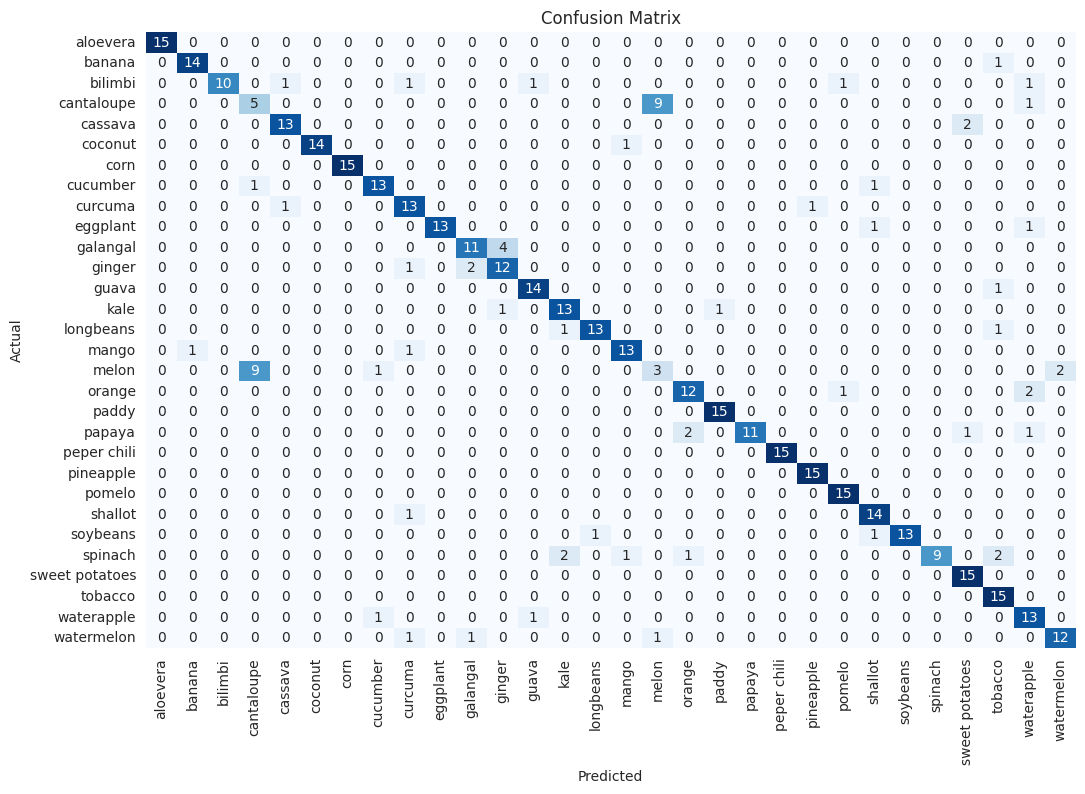

Classification Report:
----------------------
                 precision    recall  f1-score   support

      aloevera     1.0000    1.0000    1.0000        15
        banana     0.9333    0.9333    0.9333        15
       bilimbi     1.0000    0.6667    0.8000        15
    cantaloupe     0.3333    0.3333    0.3333        15
       cassava     0.8667    0.8667    0.8667        15
       coconut     1.0000    0.9333    0.9655        15
          corn     1.0000    1.0000    1.0000        15
      cucumber     0.8667    0.8667    0.8667        15
       curcuma     0.7222    0.8667    0.7879        15
      eggplant     1.0000    0.8667    0.9286        15
      galangal     0.7857    0.7333    0.7586        15
        ginger     0.7059    0.8000    0.7500        15
         guava     0.8750    0.9333    0.9032        15
          kale     0.8125    0.8667    0.8387        15
     longbeans     0.9286    0.8667    0.8966        15
         mango     0.8667    0.8667    0.8667        15


In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0

    if(len(models)==0):
        for i in links:
            models.append(tf.keras.models.load_model(i,custom_objects={'KerasLayer':hub.KerasLayer}, compile=False))

    if(len(predictions)==0):
        for model in models:
            predictions.append(model.predict(test_gen))


    preds=np.mean(predictions, axis=0)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

We achieved an F1 score of 83,6% which is not to bad considering we limited the number of images in train_df to 120  
images per class and reduced the image size to 200 X 260. This was done to reduce training time at the expense of the  
F1 score.